# Model combination

In [1]:
using RxInfer, Distributions, Random, PyPlot

### Data generation

In [2]:
# specify distribution
dist = MixtureModel(Normal, [(-2.0, 1.0), (0.0, 1.0), (3.0, 1.0)], [0.2, 0.5, 0.3]);

In [3]:
function generate_data(dist, nr_samples; rng=MersenneTwister(123))

    # sample from distribution
    samples = rand(rng, dist, nr_samples)

    # return samples
    return samples

end;

In [4]:
data = generate_data(dist, 10000);

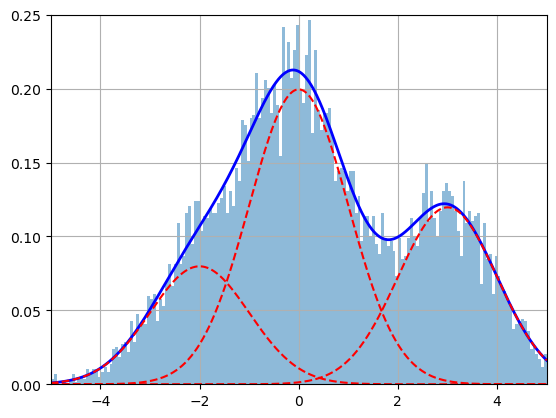

(0.0, 0.25)

In [5]:
plt.plot(-5:0.01:5, map(x -> pdf(dist, x), -5:0.01:5), color="blue", linewidth=2)
plt.hist(data, density="relative", bins=200, alpha=0.5)
plt.plot(-5:0.01:5, map(x -> dist.prior.p[1]*pdf(dist.components[1], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[2]*pdf(dist.components[2], x), -5:0.01:5), color="red", linestyle="--")
plt.plot(-5:0.01:5, map(x -> dist.prior.p[3]*pdf(dist.components[3], x), -5:0.01:5), color="red", linestyle="--")
plt.grid()
plt.xlim(-5, 5)
plt.ylim(0, 0.25)

## Model specification

In [45]:
@rule Categorical(:p, Marginalisation) (m_out::Categorical, q_out::PointMass) = begin
    return Dirichlet(probvec(q_out) .+ one(eltype(probvec(q_out))))
end

In [6]:
struct EnforceMarginalFunctionalDependency <: ReactiveMP.AbstractNodeFunctionalDependenciesPipeline
    edge :: Symbol
end

function ReactiveMP.message_dependencies(::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    return ReactiveMP.message_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
end

function ReactiveMP.marginal_dependencies(enforce::EnforceMarginalFunctionalDependency, nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    default = ReactiveMP.marginal_dependencies(ReactiveMP.DefaultFunctionalDependencies(), nodeinterfaces, nodelocalmarginals, varcluster, cindex, iindex)
    index   = ReactiveMP.findnext(i -> name(i) === enforce.edge, nodeinterfaces, 1)
    if index === iindex 
        return default
    end
    vmarginal = ReactiveMP.getmarginal(ReactiveMP.connectedvar(nodeinterfaces[index]), IncludeAll())
    loc = ReactiveMP.FactorNodeLocalMarginal(-1, index, enforce.edge)
    ReactiveMP.setstream!(loc, vmarginal)
    # Find insertion position (probably might be implemented more efficiently)
    insertafter = sum(first(el) < iindex ? 1 : 0 for el in default; init = 0)
    return ReactiveMP.TupleTools.insertafter(default, insertafter, (loc, ))
end

In [14]:
# function for using hard switching
function ReactiveMP.functional_dependencies(::EnforceMarginalFunctionalDependency, factornode::SwitchNode{N, F}, iindex::Int) where {N, F <: FullFactorisation}
    message_dependencies = if iindex === 1
        # output depends on:
        (factornode.inputs,)
    elseif iindex === 2
        # switch depends on:
        (factornode.out, factornode.inputs)
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.out, )
    else
        error("Bad index in functional_dependencies for SwitchNode")
    end

    marginal_dependencies = if iindex === 1
        # output depends on:
        (factornode.switch,)
    elseif iindex == 2
        #  switch depends on
        ()
    elseif 2 < iindex <= N + 2
        # k'th input depends on:
        (factornode.switch,)
    else
        error("Bad index in function_dependencies for SwitchNode")
    end
    # println(marginal_dependencies)
    return message_dependencies, marginal_dependencies
end


In [41]:
# create an observable that is used to compute the switch with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::SwitchNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface, NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface  = messages[1]
    inputsinterfaces = messages[2]

    msgs_names = Val{(name(switchinterface), name(inputsinterfaces[1]))}
    msgs_observable =
    combineLatest((ReactiveMP.messagein(switchinterface), combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew())), PushNew()) |>
        map_to((ReactiveMP.messagein(switchinterface), ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces))))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the output with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::SwitchNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{NTuple{N, ReactiveMP.IndexedNodeInterface}}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    inputsinterfaces = messages[1]

    msgs_names = Val{(name(inputsinterfaces[1]), )}
    msgs_observable =
    combineLatest(map((input) -> ReactiveMP.messagein(input), inputsinterfaces), PushNew()) |>
        map_to((ReactiveMP.ManyOf(map((input) -> ReactiveMP.messagein(input), inputsinterfaces)),))
    return msgs_names, msgs_observable
end

# create an observable that is used to compute the input with pipeline constraints
function ReactiveMP.get_messages_observable(factornode::SwitchNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, messages::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    outputinterface = messages[1]

    msgs_names = Val{(name(outputinterface), )}
    msgs_observable = combineLatestUpdates((ReactiveMP.messagein(outputinterface), ), PushNew())
    return msgs_names, msgs_observable
end

function ReactiveMP.get_marginals_observable(factornode::SwitchNode{N, F, Nothing, ReactiveMP.FactorNodePipeline{P, EmptyPipelineStage}}, marginals::Tuple{ReactiveMP.NodeInterface}) where {N, F <: FullFactorisation, P <: EnforceMarginalFunctionalDependency}
    switchinterface = marginals[1]

    marginal_names       = Val{(name(switchinterface), )}
    marginals_observable = combineLatestUpdates((getmarginal(ReactiveMP.connectedvar(switchinterface), IncludeAll()), ), PushNew())

    return marginal_names, marginals_observable
end

In [42]:
@model function model_combination()

    # specify experimental outcomes
    y = datavar(Float64)

    # specify initial distribution over clusters
    α ~ Dirichlet(0.01 .* ones(3))

    # specify initial guess as to who is right
    z ~ Categorical(α) where { pipeline = EnforceMarginalFunctionalDependency(:out) }

    θ1 ~ NormalMeanPrecision(-2, 1000)
    θ2 ~ NormalMeanPrecision(0, 1000)
    θ3 ~ NormalMeanPrecision(3, 1000)

    # specify mixture prior Distribution
    θ ~ Switch(z, (θ1, θ2, θ3)) where { pipeline = EnforceMarginalFunctionalDependency(:switch) }
    
    #  specify observation noise model
    y ~ NormalMeanPrecision(θ, 1.0)

    return y, θ, θ1, θ2, θ3, z, α

end

In [43]:
@constraints function constraints_combination()
    q(z) :: PointMass
end

constraints_combination (generic function with 1 method)

In [49]:
data[1]

3.003103090722938

In [46]:
results_combination = inference(
    model = model_combination(), 
    data  = (y = data[1], ),
    constraints = constraints_combination(),
    returnvars = (θ = KeepLast(), θ1 = KeepLast(), θ2 = KeepLast(), θ3 = KeepLast(), z=KeepLast(), α=KeepLast()),
    options = ( addons = (AddonLogScale(), ), )
)

Inference results:
  Posteriors       | available for (α, θ1, θ3, θ2, z, θ)


In [47]:
results_combination.posteriors[:z]

Marginal(PointMass{Vector{Float64}}([0.0, 0.0, 1.0])) with (AddonLogScale{Float64}(-2.007056623352944),)

In [48]:
mean(results_combination.posteriors[:α])

3-element Vector{Float64}:
 0.009708737864077681
 0.009708737864077681
 0.9805825242718447

In [51]:
results_combination.posteriors[:θ1]

Marginal(NormalMeanPrecision{Float64}(μ=-2.0, w=1000.0)) with (AddonLogScale{Int64}(0),)

In [52]:
results_combination.posteriors[:θ2]

Marginal(NormalMeanPrecision{Float64}(μ=0.0, w=1000.0)) with (AddonLogScale{Int64}(0),)

In [53]:
results_combination.posteriors[:θ3]

Marginal(NormalWeightedMeanPrecision{Float64}(xi=3003.003103090723, w=1001.0)) with (AddonLogScale{Float64}(-0.9194430931474556),)